In [1]:
# import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm

In [ ]:
embedding_model = EmbeddingModel()

In [105]:
from imp import reload
import rl_dqn
import environment
reload(rl_dqn)
reload(environment)


from rl_dqn import ReplayMemory, DQN, Transition
from embedding import EmbeddingModel
from environment import OriginAgent, DialougeEnv



origin_agent = OriginAgent()
env = DialougeEnv(origin_agent,embedding_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 600

return_list = []

In [107]:
for i_episode in tqdm.tqdm(range(num_episodes)):
    # Initialize the environment and get it's state
    returns = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        returns += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            return_list.append(returns)
            # plot_durations()
            break
    

  0%|                                                                                                                        | 0/600 [00:00<?, ?it/s]/tmp/ipykernel_752/1040571505.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  0%|▏                                                                                                               | 1/600 [00:00<02:43,  3.66it/s]/tmp/ipykernel_752/1040571505.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
100%|███████████████████████████████████████████████████████████████

In [ ]:
env.history[0].substitutes

In [ ]:
self = origin_agent

In [54]:
context_id = random.choice(self.context_ids)
context = self.contexts[context_id]['context']
target = self.contexts[context_id]['targets'][0]
target_text = target['target']
substitutes = [(sub['substitute'],sub['label_score']) for sub in target['substitutes']]
sorted_subs = sorted(substitutes,key=lambda x:x[1],reverse=True)

In [55]:
sorted_subs

[('arise', 0.7),
 ('rise', 0.5),
 ('erect', 0.3),
 ('stop', 0.2),
 ('rest', 0.2),
 ('hold', 0.2),
 ('be vertical', 0.2),
 ('settle', 0.2),
 ('position', 0.2),
 ('remain', 0.2),
 ('be or get upright be', 0.2),
 ('pause', 0.1),
 ('halt', 0.1),
 ('obtain', 0.1),
 ('rank', 0.1),
 ('prevail', 0.1),
 ('mount', 0.1),
 ('belong', 0.0),
 ('put', 0.0),
 ('stay', 0.0),
 ('be situated', 0.0),
 ('dispose', 0.0),
 ('be valid', 0.0),
 ('poise', 0.0),
 ('locate', 0.0),
 ('continue', 0.0),
 ('cock', 0.0),
 ('set', 0.0),
 ('last', 0.0),
 ('occupy', 0.0),
 ('lift', 0.0),
 ('endure', 0.0),
 ('jump up', 0.0),
 ('get up', 0.0),
 ('take up', 0.0),
 ('be on feet', 0.0),
 ('place', 0.0),
 ('fill', 0.0),
 ('become upright', 0.0),
 ('be in force, exist be located,', 0.0)]

Complete


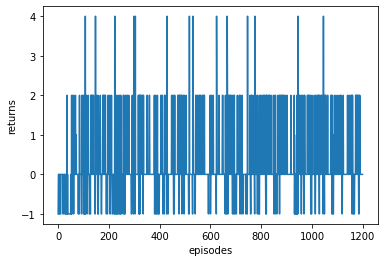

<Figure size 432x288 with 0 Axes>

In [109]:
x = list(range(len(return_list)))
plt.plot(x,return_list)
plt.xlabel("episodes")
plt.ylabel("returns")
plt.figure()

print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()